In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/cmmd/notebooks

/content/gdrive/My Drive/cmmd/notebooks


In [ ]:
!pip install -r ../requirements.txt

     |████████████████████████████████| 1.9MB 7.2MB/s 
     |████████████████████████████████| 655kB 26.7MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp37-none-any.whl size=67179 sha256=f5103ffeaaeed0e8f54adf5f7ca8d31b3eb1ff6b575e2a66cc37295b76305b4b
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [ ]:
from dotenv import dotenv_values
import urllib
import zipfile
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from pandas_profiling import ProfileReport

import pydicom 
import matplotlib.pyplot as plt
%matplotlib inline
# add current package folder to path to be able to import custom (parent) module 
import os, sys
dir1 = os.path.abspath('..')
if not dir1 in sys.path: sys.path.append(dir1)
from src.tcia_client import TCIAClient, printServerResponse

# contains secret API key
secret_env = dotenv_values('.env')

KEY = secret_env.get('TCIA_API_KEY', 'api-key-is-missing')
BASEURL = secret_env.get('BASEURL', 'https://services.cancerimagingarchive.net/services/v4/TCIA/query')
COLLECTION = 'CMMD'

In [ ]:
tcia_client = TCIAClient(credentials = KEY, baseUrl = BASEURL)

#### Download metadata/clinical data file

In [ ]:
# download metadata file
CLINICAL_DATA_URL='https://wiki.cancerimagingarchive.net/download/attachments/70230508/CMMD_clinicaldata_revision.xlsx?api=v2'
!test -f ../data/clinical_data.xlsx || wget "{CLINICAL_DATA_URL}" -O ../data/clinical_data.xlsx
meta = pd.read_excel('../data/clinical_data.xlsx', keep_default_na=False)
print(meta.shape)
meta.head()

(1872, 7)


,ID1,LeftRight,Age,number,abnormality,classification,subtype
0,D1-0001,R,44,2,calcification,Benign,
1,D1-0002,L,40,2,calcification,Benign,
2,D1-0003,L,39,2,calcification,Benign,
3,D1-0004,L,41,2,calcification,Benign,
4,D1-0005,R,42,2,calcification,Benign,


#### Download series information needed to download images

In [ ]:
import json
series_fp = '../data/series.csv'
if not os.path.exists(series_fp):
    # get series information of whole collection
    try:
        # seriesUID attribute is needed to download basically everything else
        response = tcia_client.get_series(collection = COLLECTION, outputFormat='json')
        response = json.loads(response.read().decode(response.info().get_content_charset('utf8')))
    except urllib.error.HTTPError as err:
        print ("Error executing " + tcia_client.GET_SERIES + ":\nError Code: ", str(err.code) , "\nMessage: " , err.read())
    # write to file
    pd.DataFrame.from_dict(response).to_csv(series_fp, index=False)
df = pd.read_csv(series_fp)
print(df.shape)
df.head()

(1775, 10)


,PatientID,StudyInstanceUID,SeriesInstanceUID,Modality,SeriesDate,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,D1-0860,1.3.6.1.4.1.14519.5.2.1.1239.1759.339893805217...,1.3.6.1.4.1.14519.5.2.1.1239.1759.332861114452...,MG,2010-07-18,BREAST,1.0,CMMD,1,2
1,D2-0140,1.3.6.1.4.1.14519.5.2.1.1239.1759.598888059044...,1.3.6.1.4.1.14519.5.2.1.1239.1759.115060983843...,MG,2010-07-18,BREAST,1.0,CMMD,1,4
2,D2-0205,1.3.6.1.4.1.14519.5.2.1.1239.1759.101522599910...,1.3.6.1.4.1.14519.5.2.1.1239.1759.679840241695...,MG,2010-07-18,BREAST,1.0,CMMD,1,4
3,D2-0070,1.3.6.1.4.1.14519.5.2.1.1239.1759.305656210889...,1.3.6.1.4.1.14519.5.2.1.1239.1759.292414050434...,MG,2011-07-18,BREAST,1.0,CMMD,1,4
4,D1-0577,1.3.6.1.4.1.14519.5.2.1.1239.1759.192477539144...,1.3.6.1.4.1.14519.5.2.1.1239.1759.289341612985...,MG,2011-07-18,BREAST,1.0,CMMD,1,2


In [ ]:
meta.ID1.nunique(), df.PatientID.nunique()

(1775, 1775)

In [ ]:
subtypes = meta.groupby(['classification', 'subtype']).size()
subtypes

classification  subtype        
Benign                             556
Malignant                          567
                HER2-enriched      135
                Luminal A          152
                Luminal B          376
                triple negative     86
dtype: int64

Archive:  ../data/test.zip
  inflating: ../data/test/1-6a68897b16bdcfcb4e253be411fd19c5.dcm  
  inflating: ../data/test/2-a12559683bd9e4d1d821b3164d705884.dcm  
(2294, 1914) (2294, 1914)


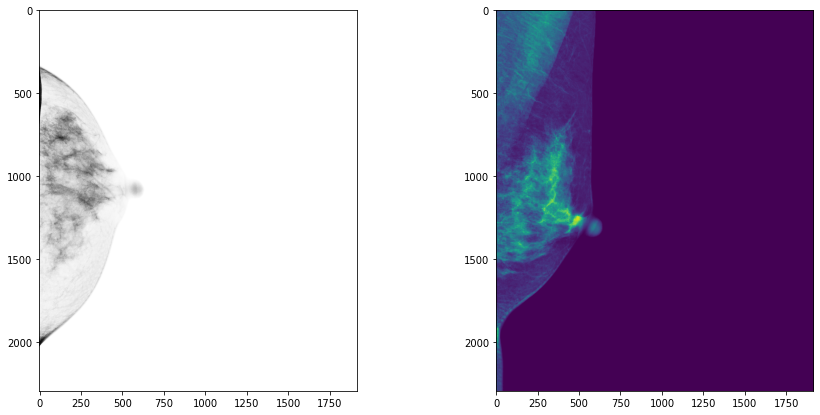

In [ ]:
if not os.path.exists('../data/test.zip'):
    tcia_client.get_image(df['SeriesInstanceUID'].iloc[0], '../data', 'test.zip')
!unzip -o ../data/test.zip -d ../data/test # && rm ../data/test.zip  # overwrite -o
img_arr = pydicom.dcmread('../data/test/1-6a68897b16bdcfcb4e253be411fd19c5.dcm').pixel_array
img_arr2 = pydicom.dcmread('../data/test/2-a12559683bd9e4d1d821b3164d705884.dcm').pixel_array
print(img_arr.shape, img_arr2.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.imshow(img_arr, cmap='Greys')
ax2.imshow(img_arr2)
plt.show()

In [ ]:
def get_image(pid, seriesuid, dest_basedir='../data/collection'):
    dest_basedir = dest_basedir[:-1] if dest_basedir.endswith(os.path.sep) else dest_basedir 
    dest_dir = f'{dest_basedir}{os.path.sep}{pid}'
    zip_fn = f'{pid}.zip'
    zip_fp = f'{dest_basedir}{os.path.sep}{zip_fn}'
    # check if folder exists and is not empty
    if os.path.exists(dest_dir) and os.path.isdir(dest_dir) and os.listdir(dest_dir):
        return dest_dir
    
    if not os.path.exists(zip_fp):
        tcia_client.get_image(seriesuid, dest_basedir, zip_fn)
    with zipfile.ZipFile(zip_fp, 'r') as zp:
        zp.extractall(dest_dir)
    os.remove(zip_fp)
    return dest_dir


### Plot sample images by classification and subtype

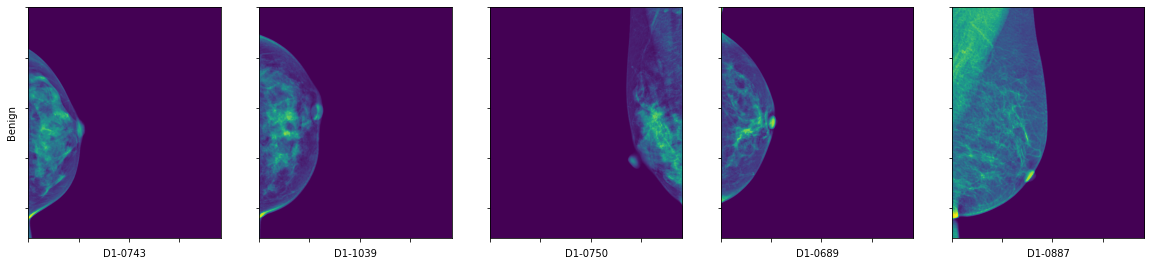

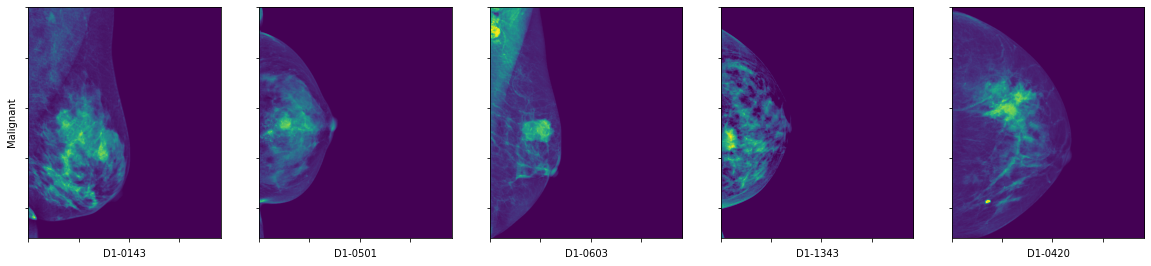

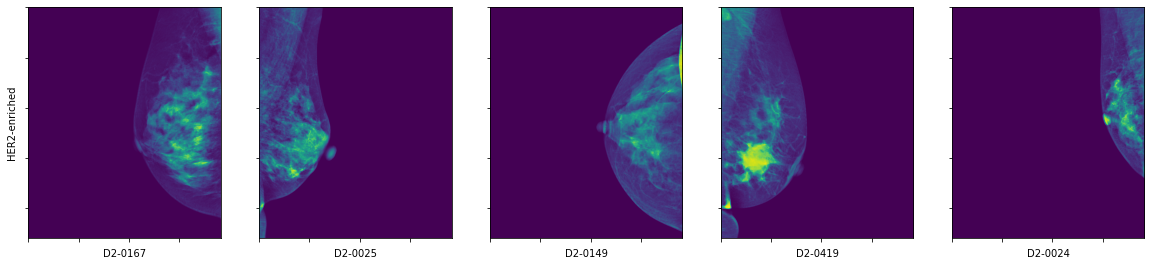

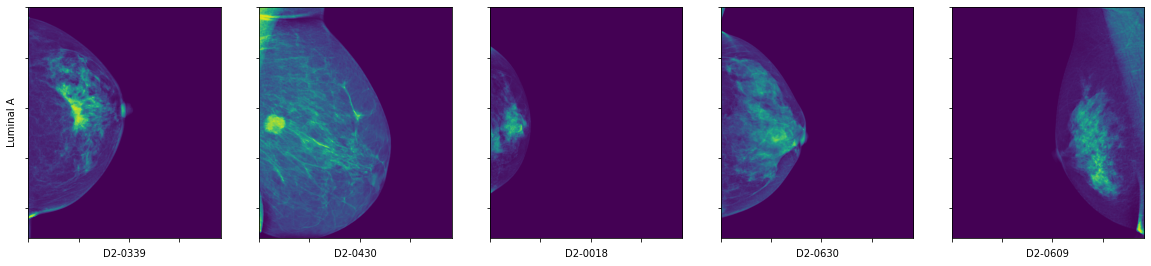

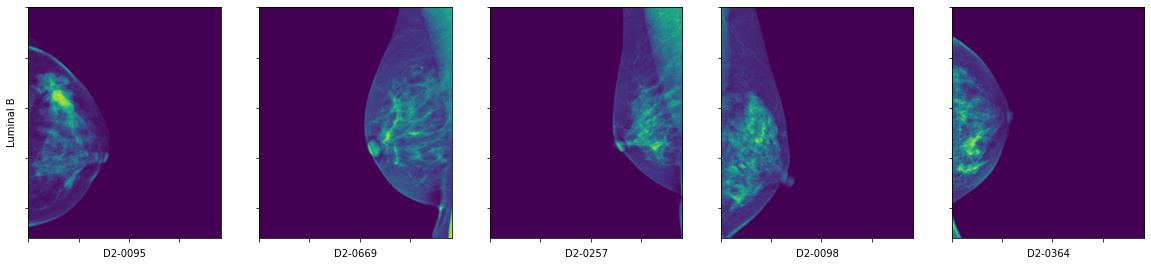

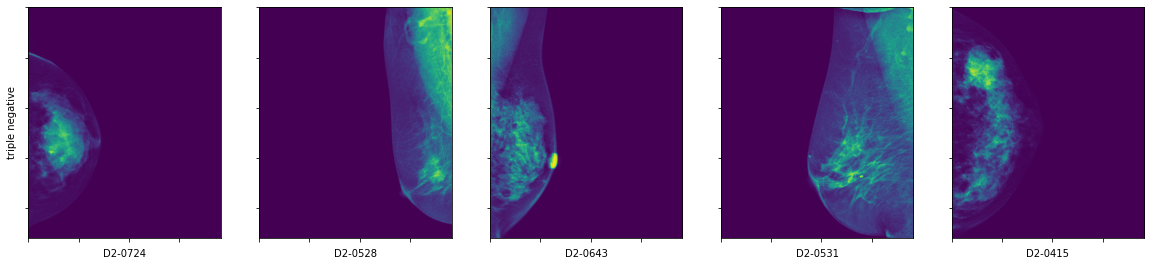

In [ ]:
np.random.seed(42)
for classe, tipo in subtypes.index:
    _ = meta[( meta['classification'] == classe ) & ( meta['subtype'] == tipo ) & ( meta['LeftRight'] == 'L') ]
    
    fig = plt.figure(figsize=(20,20))  # gridspec_kw = {'wspace':0, 'hspace':0})
    ax = [fig.add_subplot(1,5,i+1) for i in range(5)]
    
    for i, a in enumerate(ax):
        pid = np.random.choice(_.ID1)
        seriesuid = df.loc[df['PatientID']==pid]['SeriesInstanceUID'].values[0]
        img_dir = get_image(pid, seriesuid)
        image_fps = [f'{img_dir}{os.path.sep}{f}' for f in os.listdir(img_dir)]
        img_arr = pydicom.dcmread(image_fps[0]).pixel_array

        a.imshow(img_arr)
        a.set_xticklabels([])
        a.set_yticklabels([])
        if i == 0:
            a.set_ylabel(tipo if tipo else classe)
        a.set_xlabel(pid)
        a.set_aspect('equal')
        
plt.show()

#### Download images

In [25]:
df[df['PatientID']=='D1-0803']

,filepath,AcquisitionDate,BitsAllocated,BitsStored,ContentDate,HighBit,ImageLaterality,InstanceCreationTime,InstanceNumber,PatientAge,PatientID,PatientName,PatientOrientation,SOPInstanceUID,SeriesDate,SeriesInstanceUID,StudyDate,StudyInstanceUID,ViewCodeSequence,WindowCenter,WindowWidth
1034,../data/collection/D1-0803/1-789a8d76f20bac816...,2010-07-18,8,8,2010-07-18,7,R,120350,2,46,D1-0803,D1-0803,"['P', 'FL']",1.3.6.1.4.1.14519.5.2.1.1239.1759.203799370683...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.313085914038...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.777719301595...,"[(0008, 0100) Code Value ...",128,256
1035,../data/collection/D1-0803/2-ff9221b3875c502ce...,2010-07-18,8,8,2010-07-18,7,R,120350,1,46,D1-0803,D1-0803,"['P', 'L']",1.3.6.1.4.1.14519.5.2.1.1239.1759.205148420110...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.313085914038...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.777719301595...,"[(0008, 0100) Code Value ...",128,256


In [24]:
n_patients = df.PatientID.nunique() or 100
for pid in tqdm(df.PatientID.unique()[:n_patients]):
  for seriesuid in df.loc[df['PatientID']==pid, 'SeriesInstanceUID']:
    # seriesuid = df.loc[df['PatientID']==pid]['SeriesInstanceUID'].values[0]
    get_image(pid, seriesuid)


100%|██████████| 1775/1775 [00:04<00:00, 357.41it/s]


In [ ]:
dicom_fps = glob('../data/collection/**/*.dcm')
print(len(dicom_fps))

5202


In [ ]:
# a = pydicom.dcmread('../data/collection/D1-0001/1-857fc306853e3188249c5746d50ba265.dcm', stop_before_pixels=True)
# df = pd.DataFrame(a.values())
# df[0] = df[0].apply(lambda x: dicom.dataelem.DataElement_from_raw(x) if isinstance(x, dicom.dataelem.RawDataElement) else x)
# df['name'] = df[0].apply(lambda x: x.name)
# df['value'] = df[0].apply(lambda x: x.value)
# df = df[['name', 'value']]
# # df = df.loc[df['name'].str.lower() != 'pixel data']
# df

### Populate dataframe with raw DICOM attributes

In [ ]:
def get_dicom_attributes(dicom_fps):
  r = {}
  attrs = [attr for attr in dir(pydicom.dcmread(dicom_fps[0], stop_before_pixels=True)) if str.isupper(attr[0])]
  for dcm_fp in tqdm(dicom_fps):
    r[dcm_fp] = {}
    dcm = pydicom.dcmread(dcm_fp, stop_before_pixels=True)
    for attr in attrs:
      v = dcm.get(attr)
      if isinstance(v, str):
        try:
          v = int(v)
        except ValueError as e1:
          try:
            v = float(v)
          except ValueError as e:
            pass
      r[dcm_fp][attr] = v
  df = pd.DataFrame(r).T
  df.index.name = 'filepath'
  # df = df.reset_index()
  # df[['PatientID', 'filename']] = df.filepath.str.split(os.path.sep, expand=True).iloc[:, -2:]
  df = df.sort_index()#_values(['PatientName', 'InstanceNumber'])
  return df

def preprocess_dicom_attr(df):
  df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], format='%Y%m%d')
  df['ContentDate'] = pd.to_datetime(df['ContentDate'], format='%Y%m%d')
  df['SeriesDate'] = pd.to_datetime(df['SeriesDate'], format='%Y%m%d')
  df['StudyDate'] = pd.to_datetime(df['StudyDate'], format='%Y%m%d')
  df['PatientAge'] = df['PatientAge'].str.strip('Y').astype(int)
  for c in df.columns:
    uq = df[c].unique()
    if len(uq)==1:
      print(f'Dropping column "{c}" because only a single value="{uq[0]}" is present')
      df.drop(c, inplace=True, axis=1)
  return df

In [ ]:
if not os.path.exists('../data/dicom_attributes.csv'):
  if not os.path.exists('../data/dicom_attributes_raw.csv'):
    dicom_attrs = get_dicom_attributes(dicom_fps)
    dicom_attrs.to_csv('../data/dicom_attributes_raw.csv')
  df = pd.read_csv('../data/dicom_attributes_raw.csv')
  df = preprocess_dicom_attr(df)
  df = df.to_csv('../data/dicom_attributes.csv', index=False)
df = pd.read_csv('../data/dicom_attributes.csv')
df.head()

,filepath,AcquisitionDate,BitsAllocated,BitsStored,ContentDate,HighBit,ImageLaterality,InstanceCreationTime,InstanceNumber,PatientAge,PatientID,PatientName,PatientOrientation,SOPInstanceUID,SeriesDate,SeriesInstanceUID,StudyDate,StudyInstanceUID,ViewCodeSequence,WindowCenter,WindowWidth
0,../data/collection/D1-0001/1-857fc306853e31882...,2010-07-18,8,8,2010-07-18,7,R,114639,1,44,D1-0001,D1-0001,"['P', 'L']",1.3.6.1.4.1.14519.5.2.1.1239.1759.171167992666...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.623006463861...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.335790956129...,"[(0008, 0100) Code Value ...",128,256
1,../data/collection/D1-0001/2-4779097d1e45177cb...,2010-07-18,8,8,2010-07-18,7,R,114639,2,44,D1-0001,D1-0001,"['P', 'FL']",1.3.6.1.4.1.14519.5.2.1.1239.1759.174844226756...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.623006463861...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.335790956129...,"[(0008, 0100) Code Value ...",128,256
2,../data/collection/D1-0002/1-c0b2b29c33f2edb6c...,2010-07-18,8,8,2010-07-18,7,L,114640,2,40,D1-0002,D1-0002,"['A', 'FR']",1.3.6.1.4.1.14519.5.2.1.1239.1759.586725248951...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.610823649257...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.241519791051...,"[(0008, 0100) Code Value ...",128,256
3,../data/collection/D1-0002/2-bb3a6d6d2951b42fb...,2010-07-18,8,8,2010-07-18,7,L,114640,1,40,D1-0002,D1-0002,"['A', 'R']",1.3.6.1.4.1.14519.5.2.1.1239.1759.131904687741...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.610823649257...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.241519791051...,"[(0008, 0100) Code Value ...",128,256
4,../data/collection/D1-0003/1-1d913088e0bd0d61e...,2011-07-18,8,8,2011-07-18,7,L,114641,2,39,D1-0003,D1-0003,"['A', 'FR']",1.3.6.1.4.1.14519.5.2.1.1239.1759.201470332076...,2011-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.292560899611...,2011-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.113089024322...,"[(0008, 0100) Code Value ...",128,256


In [ ]:
df[ df['WindowCenter'] > df['WindowCenter'].median() ]

,filepath,AcquisitionDate,BitsAllocated,BitsStored,ContentDate,HighBit,ImageLaterality,InstanceCreationTime,InstanceNumber,PatientAge,PatientID,PatientName,PatientOrientation,SOPInstanceUID,SeriesDate,SeriesInstanceUID,StudyDate,StudyInstanceUID,ViewCodeSequence,WindowCenter,WindowWidth
1836,../data/collection/D1-1343/1-3fe7934b2199e649a...,2010-07-18,16,16,2010-07-18,15,L,121926,1,41,D1-1343,D1-1343,"['A', 'R']",1.3.6.1.4.1.14519.5.2.1.1239.1759.845374751144...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.338921544064...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.195542464785...,"[(0008, 0100) Code Value ...",32768,65536
1837,../data/collection/D1-1343/2-c0eee722046eb29dc...,2010-07-18,16,16,2010-07-18,15,L,121926,2,41,D1-1343,D1-1343,"['A', 'FR']",1.3.6.1.4.1.14519.5.2.1.1239.1759.832289374418...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.338921544064...,2010-07-18,1.3.6.1.4.1.14519.5.2.1.1239.1759.195542464785...,"[(0008, 0100) Code Value ...",32768,65536


In [ ]:
## How many mamographies ? TCIA website reports 3,728
df_labelled = pd.merge(df, meta, left_on=['PatientName', 'ImageLaterality'], right_on=['ID1', 'LeftRight'])
df_labelled.shape[0]

3744

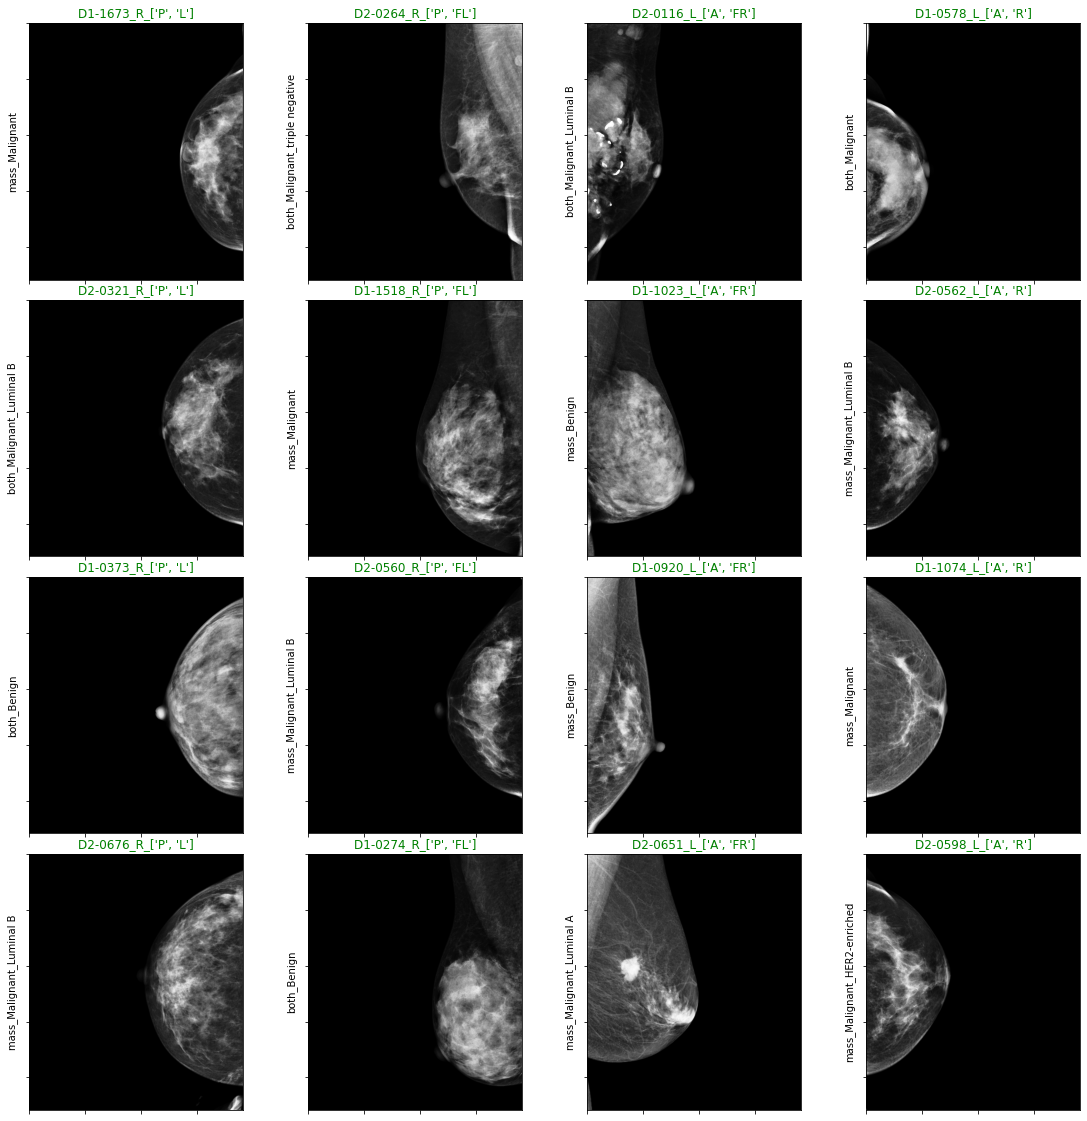

In [ ]:
%matplotlib inline

np.random.seed(4242)
f, axs = plt.subplots(4, 4, figsize=(20,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.08)
for i, ax in enumerate(axs.flatten()):
  df_ = df_labelled[df_labelled['PatientOrientation']==df_labelled['PatientOrientation'].unique()[i%4]]
  idx = np.random.choice(df_.index)
  pid, lr, view, fp = df_.loc[idx][['PatientName', 'ImageLaterality', 'PatientOrientation', 'filepath']]
  identifier = '_'.join([pid, lr, view]).strip('_')

  try:
    tipo, label_, sublabel = df_labelled.loc[(df_labelled['LeftRight'] == lr) & (df_labelled['ID1'] == pid), ['abnormality', 'classification', 'subtype']].values[0]
    label = '_'.join([tipo, label_, sublabel]).strip('_')
  except IndexError:
    label = 'No patology'

  dcm = pydicom.dcmread(fp)
  img = dcm.pixel_array
  ax.imshow(img, cmap='Greys_r')
  ax.set_title(identifier, color='green')
  ax.set_ylabel(label)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
#plt.close()

In [ ]:
# report = ProfileReport(df, title=f'{COLLECTION} summary report')
# # ProfileReport(df, explorative=True)
# report

In [ ]:
classes = pd.DataFrame({i.strip('_'):[cnt]for i,cnt in {'_'.join(i):cnt for i, cnt in dict(meta.groupby(["abnormality", "classification", "subtype"]).size()).items()}.items()}, index=['Count']).T
classes

,Count
both_Benign,80
both_Malignant,147
both_Malignant_HER2-enriched,62
both_Malignant_Luminal A,38
both_Malignant_Luminal B,120
both_Malignant_triple negative,14
calcification_Benign,64
calcification_Malignant,100
calcification_Malignant_HER2-enriched,31
calcification_Malignant_Luminal A,18


### Convert (all) DICOM to PNG

In [ ]:
import png
from tqdm import tqdm
import logging
logger = logging.getLogger('my_logger')

def dicom_to_png(file, dest_fp, overwrite=False, greyscale=True):
    if os.path.exists(dest_fp) and not overwrite:
      return
    ds = pydicom.dcmread(file)

    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array#.astype(float)
    shape = image_2d.shape
    if shape != (2294, 1914):
      logger.warning(f'Shape for image {file} is {shape} instead of (2294, 1914)')
    # # Rescaling grey scale between 0-255
    # image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    # # Convert to uint
    # image_2d_scaled = np.uint8(image_2d_scaled)

    # Write the PNG file
    with open(dest_fp, 'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=greyscale)
        w.write(png_file, image_2d)#_scaled)

for class_name in classes.index:
  if not os.path.exists(f'../data/raw/{class_name}'):
    os.makedirs(f'../data/raw/{class_name}')

for idx, row in tqdm(meta.iterrows()):
  class_name = f'{row["abnormality"]}_{row["classification"]}{"_"+row["subtype"] if row["subtype"] else ""}'
  dest_path = f'../data/raw/{class_name}'
  laterality = row['LeftRight']
  df_ = df.loc[( df['PatientID'] == row['ID1'] ) & ( df['ImageLaterality'] == row['LeftRight'] )]
  for idx_, row_ in df_.iterrows():
    pid = row_['PatientID']
    orientation = '-'.join(eval(row_['PatientOrientation']))
    file_name = f'{pid}_{laterality}_{orientation}'
    dest_fp = f'{dest_path}/{file_name}.png'
    dicom_to_png(row_['filepath'], dest_fp)

1872it [00:09, 196.06it/s]


In [29]:
fps = glob('../data/raw/*/*.png')
fp = fps[0]
len(fps)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-505831420121>", line 2, in <module>
    fp = fps[0]
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 313, in

IndexError: ignored

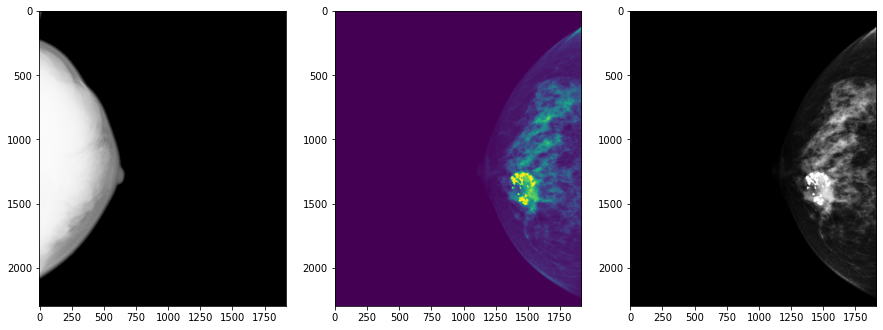

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(fp)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
ax1.imshow(pydicom.dcmread(glob('../data/collection/D1-0892/*dcm')[0]).pixel_array, cmap='Greys_r')
ax2.imshow(img)
ax3.imshow(img, cmap='Greys_r')

#### Upload to GCStorage (needed to use TPU)

In [ ]:
# from google.colab import auth
# auth.authenticate_user()
# 
# project_id = 'inspiring-orb-318912'
# !gcloud config set project {project_id}
# !gsutil ls

In [ ]:
# !gsutil -m rsync -r ../data/raw/mass_Benign/ gs://{bucket_name}/
# !gsutil -m cp -r ../data/raw/mass_Malignant_* gs://{bucket_name}/mass_Malignants